In [ ]:
# %rm -rf /content/TB

# ResNet50

### Importing Libraries

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import argparse
import cv2
import os

### Download Dataset

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/saife245/tuberculosis-image-datasets'
od.download(dataset_url)

100%|██████████| 456M/456M [00:03<00:00, 132MB/s]

In [ ]:
import os

data_dir = './tuberculosis-image-datasets'
print(os.listdir(data_dir))

['tuberculosis-phonecamera']


In [ ]:
print(os.listdir(data_dir+'/tuberculosis-phonecamera')[:5])

['tuberculosis-phone-0688.jpg', 'tuberculosis-phone-1018.jpg', 'tuberculosis-phone-0062.jpg', 'tuberculosis-phone-0250.xml', 'tuberculosis-phone-0812.xml']


In [ ]:
classes = ['negative','positive']
classes

['negative', 'positive']

### Data Augmentation

We have many sputum smear images of Positive-Tb, but only one for Negative-TB. So to address the Classification Imbalance problem, we have to augment the Negative-TB image.

In [ ]:
os.makedirs("./Negative_Tb_images")
#add negative TB image in this folder

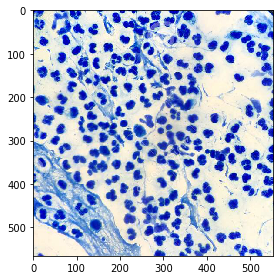

In [ ]:
negative_tb = imread("./Negative_Tb_images/Negative-Tb.jpg")
imshow(negative_tb)

In [ ]:
pip install Augmentor

In [ ]:
import Augmentor

p = Augmentor.Pipeline("./Negative_Tb_images")
p.random_brightness(probability=0.5,min_factor=0.2,max_factor=1.0)
p.random_contrast(probability=0.7,min_factor=0.2,max_factor=1.0)
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.flip_left_right(probability=0.5)
p.rotate90(probability=0.5)
p.rotate270(probability=0.5)
p.flip_top_bottom(probability=0.5)

p.sample(60)

Initialised with 1 image(s) found.
Output directory set to ./Negative_Tb_images/output.

Processing <PIL.Image.Image image mode=RGB size=554x566 at 0x7F5758D774D0>: 100%|██████████| 60/60 [00:03<00:00, 17.98 Samples/s]


Now, 60 TB-ve augmented images would have been created.

### Moving files

In [ ]:
#Moving positive TB Image files to './TB/tb+' folder
#Moving negative TB Image files to './TB/tb-' folder

import shutil

root_dir = './'
posClsSrc = './tuberculosis-image-datasets/tuberculosis-phonecamera/'
negClsSrc = './Negative_Tb_images/output/'

os.makedirs(root_dir +'./TB/tb+')
os.makedirs(root_dir +'./TB/tb-')

# giving file extension
ext = ('jpg')

# iterating over all files in posClsSrc
i = 0
for files in os.listdir(posClsSrc):
    if i<=60:
      if files.endswith(ext):
        pos_src_path =f"./tuberculosis-image-datasets/tuberculosis-phonecamera/{files}" 
        pos_dest_path = f"./TB/tb+/{files}" 
        shutil.copy(pos_src_path, pos_dest_path)
        i+=1
      else:
        continue
    else:
      break

# iterating over all files in negClsSrc
for files in os.listdir(negClsSrc):
    if files.endswith(ext):
        neg_src_path = f"./Negative_Tb_images/output/{files}" 
        neg_dest_path = f"./TB/tb-/{files}" 
        shutil.copy(neg_src_path, neg_dest_path)
    else:
        continue


### Labelind Images

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("./TB"))
imagePaths[:6]

[INFO] loading images...


['./TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_7d2abf0c-416b-4e29-b000-b7a3fcb54eec.jpg',
 './TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_592b5ea8-d111-49a2-91fd-92a7ff7a888c.jpg',
 './TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_9d9cd7d3-5215-4e49-b998-86a715c0f7e4.jpg',
 './TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_69d8bbf9-e0a4-49b9-98b9-7aa7db513af9.jpg',
 './TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_2a85570f-a8aa-48ba-ac47-5fdb18eaa8e3.jpg',
 './TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_53560440-9c44-4f3b-b97e-95c3b377ce73.jpg']

In [ ]:
imagePaths[1].split(os.path.sep)

['.',
 'TB',
 'tb-',
 'Negative_Tb_images_original_Negative-Tb.jpg_592b5ea8-d111-49a2-91fd-92a7ff7a888c.jpg']

In [ ]:
imagePaths[60].split(os.path.sep)[-2]

'tb+'

In [ ]:
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

  #preprocess image by converting to RGB channel ordering, and resizing it to 224×224 pixels
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

In [ ]:
len(data),len(labels)

(121, 121)

In [ ]:
labels[55:65]

['tb-', 'tb-', 'tb-', 'tb-', 'tb-', 'tb+', 'tb+', 'tb+', 'tb+', 'tb+']

### convert the data and labels to NumPy arrays

In [ ]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

### One-Hot Encoding

In [ ]:
# perform encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
lb.classes_

array(['tb+', 'tb-'], dtype='<U3')

### Train-Test-Split

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42, shuffle=True)

In [ ]:
len(trainX),len(trainY),len(testX),len(testY)

(96, 96, 25, 25)

In [ ]:
# to generalize model , Im perform augmentation - roation either clock or anti-clock
trainAug = ImageDataGenerator(rotation_range=15,	fill_mode="nearest")

###  ResNet50 Model

In [ ]:
baseModel = ResNet50(weights="imagenet", include_top=False,
                     input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


ResNet-50 Model Training

In [ ]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 8

In [ ]:
# compile our model
print("Compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,	metrics=["accuracy"])

# train the head of the network
print("Training head...")
H = model.fit_generator(trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS)

Compiling model...
Training head...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
12/12 [==============================] - 28s 2s/step - loss: 0.7808 - accuracy: 0.5312
Epoch 2/100
12/12 [==============================] - 17s 1s/step - loss: 0.6786 - accuracy: 0.6042
Epoch 3/100
12/12 [==============================] - 17s 1s/step - loss: 0.6545 - accuracy: 0.6667
Epoch 4/100
12/12 [==============================] - 16s 1s/step - loss: 0.6012 - accuracy: 0.7604
Epoch 5/100
12/12 [==============================] - 16s 1s/step - loss: 0.5623 - accuracy: 0.7917
Epoch 6/100
12/12 [==============================] - 18s 2s/step - loss: 0.5096 - accuracy: 0.7708
Epoch 7/100
12/12 [==============================] - 17s 1s/step - loss: 0.4818 - accuracy: 0.8021
Epoch 8/100
12/12 [==============================] - 16s 1s/step - loss: 0.4610 - accuracy: 0.8333
Epoch 9/100
12/12 [==============================] - 16s 1s/step - loss: 0.4360 - accuracy: 0.8333
Epoch 10/100
12/12 [==============================] - 17s 1s/step - loss: 0.4551 - accuracy: 0.8021
Epoch 11/

### Training Evaluation

In [ ]:
# make predictions on the train set
print("[INFO] evaluating network...")
predIdxs2 = model.predict(trainX, batch_size=BS)

# index of the
# label with corresponding largest predicted probability

predIdxs2 = np.argmax(predIdxs2, axis=1)

# classification report
print(classification_report(trainY.argmax(axis=1), predIdxs2,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

         tb+       0.87      1.00      0.93        48
         tb-       1.00      0.85      0.92        48

    accuracy                           0.93        96
   macro avg       0.94      0.93      0.93        96
weighted avg       0.94      0.93      0.93        96



In [ ]:
traincm = confusion_matrix(trainY.argmax(axis=1), predIdxs2)
total = sum(sum(traincm))
acc = (traincm[0, 0] + traincm[1, 1]) / total
sensitivity = traincm[0, 0] / (traincm[0, 0] + traincm[0, 1])
specificity = traincm[1, 1] / (traincm[1, 0] + traincm[1, 1])
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

accuracy: 0.9271
sensitivity: 1.0000
specificity: 0.8542


In [ ]:
lb.classes_

array(['tb+', 'tb-'], dtype='<U3')

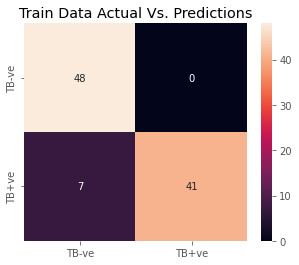

In [ ]:
plt.figure(figsize = (5,4))
plt.title('Train Data Actual Vs. Predictions')
sns.heatmap(traincm,
            yticklabels=['TB-ve', 'TB+ve'],
            xticklabels=['TB-ve', 'TB+ve'],
            annot=True);

### Test Evaluation

In [ ]:
# make predictions on the test set
print("[INFO] evaluating network...")
predIdxs1 = model.predict(testX, batch_size=BS)

# index of the
# label with corresponding largest predicted probability

predIdxs1 = np.argmax(predIdxs1, axis=1)

# classification report
print(classification_report(testY.argmax(axis=1), predIdxs1,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

         tb+       0.87      1.00      0.93        13
         tb-       1.00      0.83      0.91        12

    accuracy                           0.92        25
   macro avg       0.93      0.92      0.92        25
weighted avg       0.93      0.92      0.92        25



In [ ]:
cm1 = confusion_matrix(testY.argmax(axis=1), predIdxs1)
total = sum(sum(cm1))
acc1 = (cm1[0, 0] + cm1[1, 1]) / total
sensitivity1 = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
specificity1 = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
print("Train Accuracy    : {:.4f}".format(acc1))
print("Train Sensitivity : {:.4f}".format(sensitivity1))
print("Train Specificity : {:.4f}".format(specificity1))

print()

cm2 = confusion_matrix(trainY.argmax(axis=1), predIdxs2)
total = sum(sum(cm2))
acc2 = (cm2[0, 0] + cm2[1, 1]) / total
sensitivity2 = cm2[0, 0] / (cm2[0, 0] + cm2[0, 1])
specificity2 = cm2[1, 1] / (cm2[1, 0] + cm2[1, 1])
print("Test Accuracy    : {:.4f}".format(acc2))
print("Test Sensitivity : {:.4f}".format(sensitivity2))
print("Test Specificity : {:.4f}".format(specificity2))

Train Accuracy    : 0.9200
Train Sensitivity : 1.0000
Train Specificity : 0.8333

Test Accuracy    : 0.9271
Test Sensitivity : 1.0000
Test Specificity : 0.8542


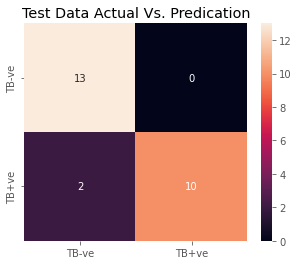

In [ ]:
plt.figure(figsize = (5,4))
plt.title('Test Data Actual Vs. Predication')
sns.heatmap(cm,
            yticklabels=['TB-ve', 'TB+ve'],
            xticklabels=['TB-ve', 'TB+ve'],
            annot=True);

### Plot

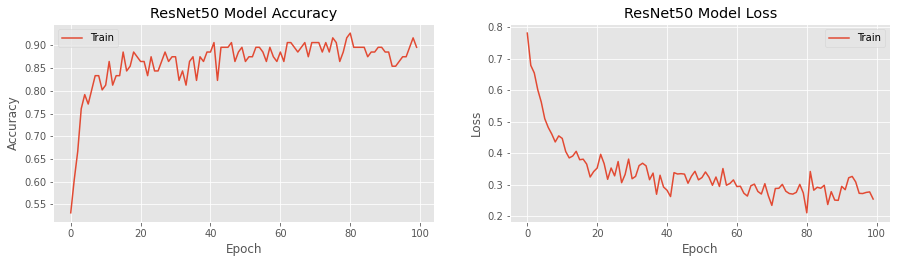

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(H.history['accuracy'])  
plt.title('ResNet50 Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Valid']) 
    
plt.subplot(222)  
plt.plot(H.history['loss'])  
plt.title('ResNet50 Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Valid']) 

plt.show()

### Predict an Image class

In [ ]:
def resnet50_predict(img):
  print(f"Label              : {lb.classes_}")
  print(f"Actual             : {testY[img:img+1]}")
  print(f"Model's Prediction : {model.predict(testX[img:img+1])}")

In [ ]:
resnet50_predict(10)

Label              : ['tb+' 'tb-']
Actual             : [[1. 0.]]
Model's Prediction : [[0.9700226  0.02997745]]


In [ ]:
resnet50_predict(15)

Label              : ['tb+' 'tb-']
Actual             : [[0. 1.]]
Model's Prediction : [[4.6421923e-30 1.0000000e+00]]


In [ ]:
model.predict(testX[:5])

In [ ]:
def resnet50_predictSingleImage(img):
  print(f"Model's Prediction : {model.predict(img)}")

# InceptionV3

In [ ]:
#code for Inception Block
#Inception Naive Version
def inception_module(x, f1, f2, f3): #f1, f2 and f3 are filter sizes for Conv1, Conv3 and Conv5 respectively.
  conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(x)#1x1 Conv layer
  conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(x)#3x3 Conv layer
  conv1 = Conv2D(f3, (5,5), padding='same', activation='relu')(x)#5x5 Conv layer
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)#3x3 max pooling with stride 1x1.
  out = concatenate([conv1, conv3, conv5, pool])#Concatenate all the filters.
  return out

Importing Necessary Libraries

In [ ]:
#Example of creating CNN with Inception Module.
from keras.models import Model
from keras import layers
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


img_input = Input(shape=(299,299,3))
classes = 1000
WEIGHTS_PATH = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
channel_axis = 3

# Creating functions used to build the model

### Conv2D with BatchNormalization and Relu

In [ ]:
#Remember, In Inception V3, every Convolutional Layer will ahve Batch Normalization and Relu Activation function.
#But by default, the Conv2D which we import doesn't do Batch Normalization or Relu.
#So, we have to create a new Conv2D function with Batch Normalization and Relu.
def conv2d_bn(x, filters, num_rows, num_cols, padding='same', strides=(1,1)):  #num_rows and num_cols are height and width of the filters.
  x = layers.Conv2D(filters, (num_rows, num_cols), padding=padding, strides=strides)(x)
  x = layers.BatchNormalization(axis=3, scale=False)(x)#we want to perform Batch Noramlization on the 3rd axis i.e., the channels.
  x = layers.Activation('relu')(x)
  return x

### Inception Block A

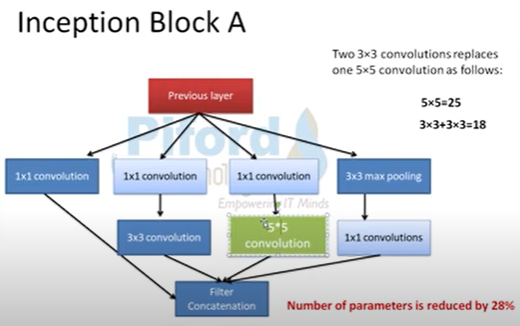

In [ ]:
def inc_block_a(x):
  branch1x1 = conv2d_bn(x, 64, 1, 1) #64 filters of size 1x1.

  branch5x5 = conv2d_bn(x, 48, 1, 1) #48 filters on size 1x1.
  branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

  branch3x3dbl = conv2d_bn(x, 64, 1, 1)
  branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
  branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

  branch_pool = layers.AveragePooling2D((3,3), strides=(1,1), padding='same')(x)
  branch_pool = conv2d_bn(branch_pool, 32, 1, 1)

  x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis)
  return x

### Reduction Block A

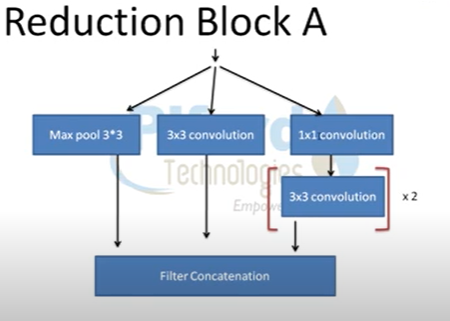

In [ ]:
def reduction_block_a(x):
  branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2,2), padding='valid') #384 filters of size 1x1.

  branch3x3dbl = conv2d_bn(x, 64, 1, 1)
  branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
  branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2,2), padding='valid')

  branch_pool = layers.MaxPooling2D((3,3), strides=(2,2))(x)

  x = layers.concatenate([branch3x3, branch3x3dbl, branch_pool], axis=channel_axis)
  return x

### Inception Block B

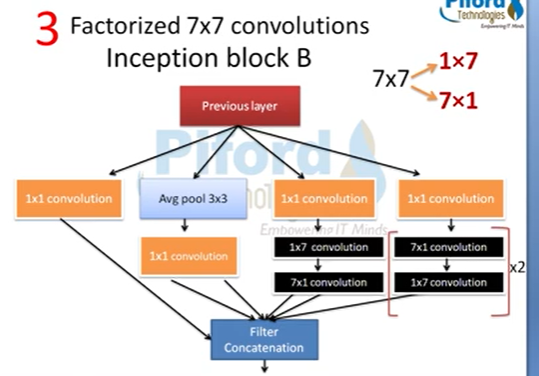

In [ ]:
#Asymmetric Factorization
#17 x 17 x 768
def inc_block_b(x):
  branch1x1 = conv2d_bn(x, 192, 1, 1) #192 filters of size 1x1.

  branch7x7 = conv2d_bn(x, 128, 1, 1) #128 filters of size 1x1.
  branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
  branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

  branch7x7dbl = conv2d_bn(x, 128, 1, 1)
  branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
  branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
  branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
  branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)

  branch_pool = layers.AveragePooling2D((3,3), strides=(1,1), padding='same')(x)
  branch_pool = conv2d_bn(branch_pool, 192, 1, 1)

  x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis)
  return x

### Reduction Block B

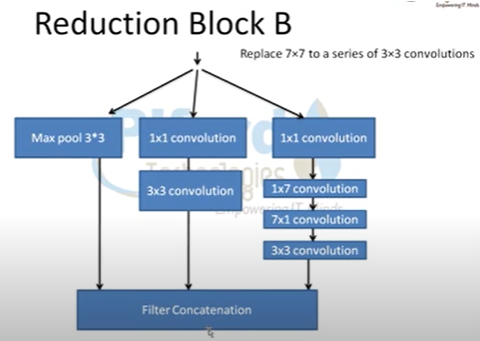

In [ ]:
#mixed 8 : 8 x 8 x 1280
def reduction_block_b(x):
  branch3x3 = conv2d_bn(x, 192, 1, 1)
  branch3x3 = conv2d_bn(branch3x3, 120, 3, 3, strides=(2,2), padding='valid')

  branch7x7x3 = conv2d_bn(x, 192, 1, 1)
  branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
  branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
  branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3, strides=(2,2), padding='valid')

  branch_pool = layers.MaxPooling2D((3,3), strides=(2,2))(x)

  x = layers.concatenate([branch3x3, branch7x7x3, branch_pool], axis=channel_axis)
  return x

### Inception Block C

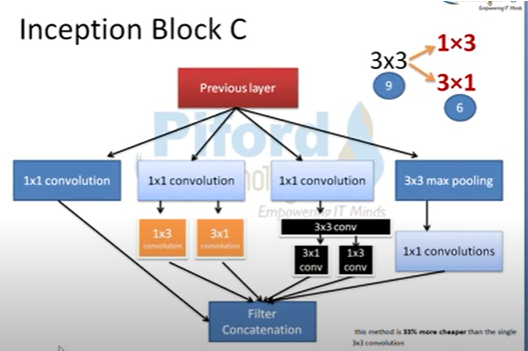

In [ ]:
def inc_block_c(x):
  branch1x1 = conv2d_bn(x, 320, 1, 1) #320 filters of size 1x1.

  branch3x3 = conv2d_bn(x, 384, 1, 1) #384 filters of size 1x1.
  branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3) #Notice that, this and
  branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1) #this layer are parallel.
  branch3x3 = layers.concatenate([branch3x3_1, branch3x3_2], axis=channel_axis)

  branch3x3dbl = conv2d_bn(x, 448, 1, 1) 
  branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
  branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3) #Also notice that, this and
  branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1) #this layer are parallel.
  branch3x3dbl = layers.concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

  branch_pool = layers.AveragePooling2D((3,3), strides=(1,1), padding='same')(x)
  branch_pool = conv2d_bn(branch_pool, 192, 1, 1)

  x = layers.concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool], axis=channel_axis)
  return x

# Training

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("./TB"))
imagePaths[:6]

[INFO] loading images...


['./TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_6d0648b2-2d34-451c-a2dd-855b58681228.jpg',
 './TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_2f2bdd7a-4c20-4054-86d0-d0c9a515c502.jpg',
 './TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_a290da44-ab7c-4912-9cdf-e7a373c84fca.jpg',
 './TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_8d5c134b-c734-41f9-8108-42ada1190015.jpg',
 './TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_d749eabc-73b0-4868-bb25-35f15c90b2e1.jpg',
 './TB/tb-/Negative_Tb_images_original_Negative-Tb.jpg_08b960d7-cac7-490f-8c39-c85a1a9fb89c.jpg']

In [ ]:
data1 = []
labels1 = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label1 = imagePath.split(os.path.sep)[-2]

  #preprocess image by converting to RGB channel ordering, and resizing it to 224×224 pixels
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (150, 150))
	# update the data and labels lists, respectively
	data1.append(image)
	labels1.append(label1)

In [ ]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data1 = np.array(data1) / 255.0
labels1 = np.array(labels1)

In [ ]:
# perform one-hot encoding on the train labels
lb1 = LabelBinarizer()
labels1 = lb1.fit_transform(labels1)
labels1 = to_categorical(labels1)

In [ ]:
lb1.classes_

array(['tb+', 'tb-'], dtype='<U3')

In [ ]:
# 80% of data for training
# remaining 20% for testing
(trainX1, testX1, trainY1, testY1) = train_test_split(data1, labels1,
	test_size=0.20, stratify=labels1, random_state=42, shuffle=True)

In [ ]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 8

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path_inception = f"{os.getcwd()}/../content/drive/MyDrive/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (150,150,3),
                               include_top  = False,
                               weights      = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
      layer.trainable = False

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [ ]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
from skimage.io import imread, imshow

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation = 'sigmoid')(x)           

model1 = Model( pre_trained_model.input, x) 

model1.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
!pip install split_folders

In [ ]:
# to generalize model , Im perform augmentation - roation either clock or anti-clock
trainAug = ImageDataGenerator(rotation_range=15,	fill_mode="nearest")

In [ ]:
# Train the head of the network
print("Training head...")
H = model1.fit_generator(trainAug.flow(trainX1, trainY1, batch_size=BS),
	steps_per_epoch=len(trainX1) // BS,
	epochs=EPOCHS)

Training head...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/100
12/12 [==============================] - 12s 671ms/step - loss: 1.5730 - acc: 0.5000
Epoch 2/100
12/12 [==============================] - 11s 949ms/step - loss: 0.7538 - acc: 0.5000
Epoch 3/100
12/12 [==============================] - 14s 1s/step - loss: 0.7007 - acc: 0.5000
Epoch 4/100
12/12 [==============================] - 19s 2s/step - loss: 0.7113 - acc: 0.5000
Epoch 5/100
12/12 [==============================] - 18s 2s/step - loss: 0.7000 - acc: 0.5000
Epoch 6/100
12/12 [==============================] - 13s 1s/step - loss: 0.7013 - acc: 0.5000
Epoch 7/100
12/12 [==============================] - 8s 630ms/step - loss: 0.6966 - acc: 0.5000
Epoch 8/100
12/12 [==============================] - 8s 632ms/step - loss: 0.6945 - acc: 0.5000
Epoch 9/100
12/12 [==============================] - 8s 636ms/step - loss: 0.6935 - acc: 0.5000
Epoch 10/100
12/12 [==============================] - 8s 636ms/step - loss: 0.6936 - acc: 0.5000
Epoch 11/100
12/12 [=========================

In [ ]:
# make predictions on the train set
print("[INFO] evaluating network...")
predIdxs1 = model1.predict(trainX1, batch_size=BS)

# index of the
# label with corresponding largest predicted probability

predIdxs1 = np.argmax(predIdxs1, axis=1)

# classification report
print(classification_report(trainY1.argmax(axis=1), predIdxs1,
	target_names=lb1.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

         tb+       0.50      1.00      0.67        48
         tb-       0.00      0.00      0.00        48

    accuracy                           0.50        96
   macro avg       0.25      0.50      0.33        96
weighted avg       0.25      0.50      0.33        96



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm2 = confusion_matrix(trainY1.argmax(axis=1), predIdxs1)
total = sum(sum(cm2))
acc2 = (cm2[0, 0] + cm2[1, 1]) / total
sensitivity2 = cm2[0, 0] / (cm2[0, 0] + cm2[0, 1])
specificity2 = cm2[1, 1] / (cm2[1, 0] + cm2[1, 1])
print("Test Accuracy    : {:.4f}".format(acc2))
print("Test Sensitivity : {:.4f}".format(sensitivity2))
print("Test Specificity : {:.4f}".format(specificity2))

Test Accuracy    : 0.5000
Test Sensitivity : 1.0000
Test Specificity : 0.0000


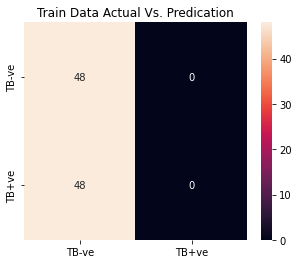

In [ ]:
plt.figure(figsize = (5,4))
plt.title('Train Data Actual Vs. Predication')
sns.heatmap(cm2,
            yticklabels=['TB-ve', 'TB+ve'],
            xticklabels=['TB-ve', 'TB+ve'],
            annot=True);

In [ ]:
# make predictions on the test set
print("[INFO] Inception V3 Test data Evaluation")
predIdxs1 = model1.predict(testX1, batch_size=BS)

# index of the
# label with corresponding largest predicted probability

predIdxs1 = np.argmax(predIdxs1, axis=1)

# classification report
print(classification_report(testY1.argmax(axis=1), predIdxs1,
	target_names=lb1.classes_))

[INFO] Inception V3 Test data Evaluation
              precision    recall  f1-score   support

         tb+       0.52      1.00      0.68        13
         tb-       0.00      0.00      0.00        12

    accuracy                           0.52        25
   macro avg       0.26      0.50      0.34        25
weighted avg       0.27      0.52      0.36        25



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm2 = confusion_matrix(testY1.argmax(axis=1), predIdxs1)
total = sum(sum(cm2))
acc2 = (cm2[0, 0] + cm2[1, 1]) / total
sensitivity2 = cm2[0, 0] / (cm2[0, 0] + cm2[0, 1])
specificity2 = cm2[1, 1] / (cm2[1, 0] + cm2[1, 1])
print("Test Accuracy    : {:.4f}".format(acc2))
print("Test Sensitivity : {:.4f}".format(sensitivity2))
print("Test Specificity : {:.4f}".format(specificity2))

Test Accuracy    : 0.5200
Test Sensitivity : 1.0000
Test Specificity : 0.0000


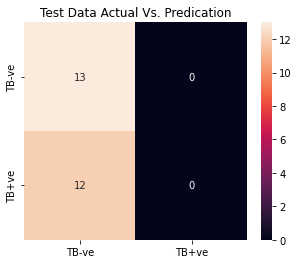

In [ ]:
plt.figure(figsize = (5,4))
plt.title('Test Data Actual Vs. Predication')
sns.heatmap(cm2,
            yticklabels=['TB-ve', 'TB+ve'],
            xticklabels=['TB-ve', 'TB+ve'],
            annot=True);

In [ ]:
def inception_v3_predict(img):
  print(f"Label              : {lb1.classes_}")
  print(f"Actual             : {testY1[img:img+1]}")
  print(f"Model's Prediction : {model1.predict(testX1[img:img+1])}")

In [ ]:
inception_v3_predict(10)

Label              : ['tb+' 'tb-']
Actual             : [[1. 0.]]
Model's Prediction : [[0.4999985]]


In [ ]:
inception_v3_predict(15)

Label              : ['tb+' 'tb-']
Actual             : [[0. 1.]]
Model's Prediction : [[0.4999985]]


KeyError: ignored

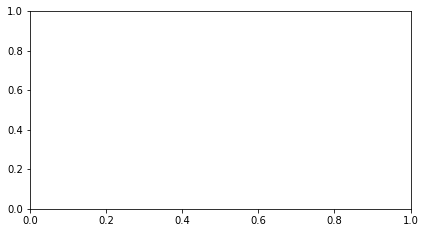

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(H.history['accuracy'])  
plt.title('ResNet50 Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Valid']) 
    
plt.subplot(222)  
plt.plot(H.history['loss'])  
plt.title('ResNet50 Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Valid']) 

plt.show()

### ViT

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 42.6 MB/s 
     |████████████████████████████████| 67 kB 3.2 MB/s 
     |████████████████████████████████| 596 kB 68.3 MB/s 


In [ ]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('/content/' + dataset.location + '/train/', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder('/content/' + dataset.location + '/valid/', transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder('/content/' + dataset.location + '/test/', transform=ToTensor())